In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os import listdir
import plotly
import plotly.graph_objs as go
import kaleido
from mpl_toolkits.mplot3d import Axes3D

In [126]:
data_t = np.load('/om/user/huidili/wmUpdate/150b50s_decode/spk_dec_input/061311Tir_spk_rate.npz')['rate_bins']
tps = np.mean(data_t, axis=1)

In [127]:
subject = 'Tir'
if subject == 'Tir':
    trial_num = 190
else:
    trial_num = 70

info = 's1'
area = 'PFC'
X = np.load(f'/om/user/huidili/wmUpdate/150b50s_decode/spk_dec_data/{subject}/{subject}_{info}_{area}_feature_label.npz')['feature']
# trial_num = 45
# condition = 'update'
# X = np.load(f'/om/user/huidili/wmUpdate/150b50s_decode/spk_dec_condition_data/{subject}/{subject}_{info}_{area}_{condition}_feature_label.npz')['feature']

In [128]:
def pca_tp(popu_X_t):
    # pca
    cov = np.cov(popu_X_t.T)
    (U, S, VT) = np.linalg.svd(cov, full_matrices=False)
    var = np.cumsum(S)/np.sum(S)
    Z_t = U[:,:2].T@popu_X_t.T
    return U, Z_t, var[1]
    

In [129]:
def add_surface(start_t, end_t, ax_min, ax_max):
    x=[ax_min, ax_min, ax_max, ax_max, ax_min, ax_min, ax_max, ax_max]
    y=[ax_min, ax_max, ax_max, ax_min, ax_min, ax_max, ax_max, ax_min]
    z=[start_t, start_t, start_t, start_t, end_t, end_t, end_t, end_t]

    return go.Mesh3d(x=x,y=y,z=z, alphahull = 0, color='grey', opacity=0.1, showscale=False)

In [130]:
def t_to_idx(t):
    return int((t-(-2))/0.05)
def t_end_to_idx(t_end):
    return int((t_end + 1.85)/0.05)
def bind_z_t(Z_t, i):
    return np.expand_dims(np.concatenate((Z_t, np.array([tps[i]]*4).reshape(1,-1)), axis=0), axis=0)

In [131]:
# compute population matrix (separate mean for each neuron and time bin)

popu_X = []
for i in range(0, X.shape[0], trial_num):
    popu_X.append(np.expand_dims(np.mean(X[i:i+trial_num], axis=0), axis=0))
popu_X = np.concatenate(popu_X, axis=0)
popu_X_mean = np.expand_dims(np.mean(popu_X, axis=0), axis=0)
popu_X = popu_X - popu_X_mean

all_var = []
for i in range(128):
    U, Z_t, var = pca_tp(popu_X[:,:,i])
    all_var.append(var)

print(np.mean(all_var))


0.807197162709276


In [132]:
step = 0.05 # ms
vel_all = []
for i in range(4):
    popu_X_item = popu_X[i]
    vel_item = []
    for t in range(1,127):
#         v = np.abs(np.mean(popu_X_item[:,t-1]) - np.mean(popu_X_item[:,t+1]))/(2*step)
        v = np.sqrt(np.sum((popu_X_item[:,t-1] - popu_X_item[:,t+1])**2))/(2*step)
        vel_item.append(v)
    vel_all.append(np.array(vel_item).reshape(1,-1))

vel_all = np.concatenate(vel_all, axis=0)
        
        

Text(0, 0.5, 'Velocity (Hz/s)')

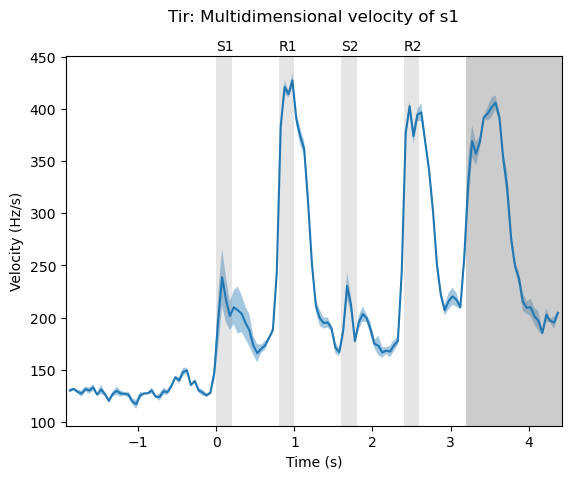

In [133]:
fig, ax = plt.subplots(figsize=(6.4,4.8))

mean = np.mean(vel_all, axis=0)
sd = np.std(vel_all, axis=0)/2
ax.plot(tps[1:127], mean)
ax.fill_between(tps[1:127], mean-sd, mean+sd, alpha=0.4)

ax.set_xlim(tps[0], tps[-1])
# ax.set_ylim(0,500)
ax_b, ax_t = ax.get_ylim()
ax_l, ax_r = ax.get_xlim()
# ax.set_ylim(ax_b, ax_t)
ax_vlines = [0, 0.2, 0.8, 1, 1.6, 1.8, 2.4, 2.6]
vline_text = ['S1', 'R1', 'S2', 'R2']
for j in range(0, 8, 2):
    ax.axvspan(ax_vlines[j], ax_vlines[j + 1], alpha=0.2, color='gray', linewidth=0)
ax.axvspan(3.2, ax_r, alpha=0.4, color='gray', linewidth=0)
for j in range(len(vline_text)):
    plt.text(ax_vlines[j * 2], ax_t * 1.02, vline_text[j], verticalalignment='center')
ax.set_title(f'{subject}: Multidimensional velocity of {info}', pad=25)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (Hz/s)')